# GRADCAM

Let's start with a pretrained VGG model

In [0]:
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image
import numpy as np
import cv2
from keras import backend as K

Using TensorFlow backend.


1.  Loading helper functions
2.  Load VGG
3. Load Image
4. Rescale image to 224x224x3 (VGG's expectation, why?)
5. Use expand_dims to convert image to a batch of size 1
6. Preprocesing normalizes our input image by subtracting mean RGB values

In [0]:
model = VGG16(weights="imagenet")
from skimage import io
dog = io.imread("https://www.rspcapetinsurance.org.au/rspca/media/images/hero/dog-insurance-hero.jpg")
dog = cv2.resize(dog, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
x = image.img_to_array(dog)
print(x.shape)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)


W0703 17:31:30.955837 140681994069888 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0703 17:31:30.989968 140681994069888 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0703 17:31:30.996300 140681994069888 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0703 17:31:31.035201 140681994069888 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



553467904/553467096 [==============================] - 29s 0us/step


W0703 17:32:01.155742 140681994069888 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0703 17:32:01.156735 140681994069888 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.



(224, 224, 3)


1. We get the predictions for the image
2. We take the topmost class index
3. Take output from the final convolutional layer
4. Also we take the output from the second last and third last convolutional layer.

In [0]:
preds = model.predict(x)
class_idx = np.argmax(preds[0])
print(class_idx)
class_output = model.output[:, class_idx]
last_conv_layer = model.get_layer("block5_conv3")
second_last_conv_layer = model.get_layer("block5_conv2")
third_last_conv_layer = model.get_layer("block5_conv1")

180


1. Compute the gradient of the class output value with respect to the feature map
2. Pool the gradients over all the axies leaving out the channel dimension
3. Weigh the output feature map with the computed gradient values

In [0]:
grads1 = K.gradients(class_output, last_conv_layer.output)[0]
print(grads1.shape)
pooled_grads1 = K.mean(grads1, axis=(0, 1, 2))
print(pooled_grads1.shape)
iterate1 = K.function([model.input], [pooled_grads1, last_conv_layer.output[0]])

pooled_grads_value1, conv_layer_output_value1 = iterate1([x])

for i in range(512):
  conv_layer_output_value1[:, :, i] *= pooled_grads_value1[i]
  
grads2 = K.gradients(class_output, second_last_conv_layer.output)[0]
print(grads2.shape)
pooled_grads2 = K.mean(grads2, axis=(0, 1, 2))
print(pooled_grads2.shape)
iterate2 = K.function([model.input], [pooled_grads2, second_last_conv_layer.output[0]])

pooled_grads_value2, conv_layer_output_value2 = iterate2([x])

for i in range(512):
  conv_layer_output_value2[:, :, i] *= pooled_grads_value2[i]


grads3 = K.gradients(class_output, third_last_conv_layer.output)[0]
print(grads3.shape)
pooled_grads3 = K.mean(grads3, axis=(0, 1, 2))
print(pooled_grads3.shape)
iterate3 = K.function([model.input], [pooled_grads3, third_last_conv_layer.output[0]])

pooled_grads_value3, conv_layer_output_value3 = iterate3([x])

for i in range(512):
  conv_layer_output_value3[:, :, i] *= pooled_grads_value3[i]

(?, 14, 14, 512)
(512,)
(?, 14, 14, 512)
(512,)
(?, 14, 14, 512)
(512,)


1. Average the weighted feature map along the channel dimension resulting in a heat map of size 14x14 
2. Normalize the heat map to make the values between 0 and 1

In [0]:
heatmap1 = np.mean(conv_layer_output_value1, axis = -1)
print(conv_layer_output_value1.shape)
print(heatmap1.shape)
heatmap1 = np.maximum(heatmap1, 0)
heatmap1 /= np.max(heatmap1)

heatmap2 = np.mean(conv_layer_output_value2, axis = -1)
print(conv_layer_output_value2.shape)
print(heatmap2.shape)
heatmap2 = np.maximum(heatmap2, 0)
heatmap2 /= np.max(heatmap2)

heatmap3 = np.mean(conv_layer_output_value3, axis = -1)
print(conv_layer_output_value3.shape)
print(heatmap3.shape)
heatmap3 = np.maximum(heatmap3, 0)
heatmap3 /= np.max(heatmap3)

(14, 14, 512)
(14, 14)
(14, 14, 512)
(14, 14)
(14, 14, 512)
(14, 14)


Show the results

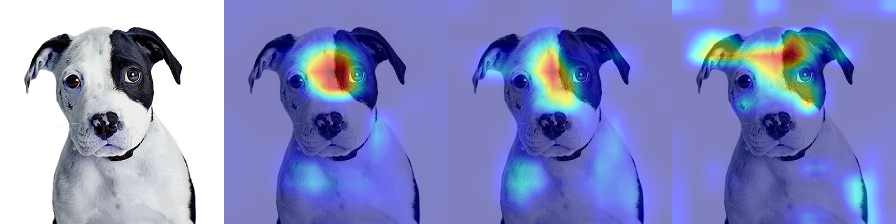

In [0]:
from google.colab.patches import cv2_imshow

heatmap1 = cv2.resize(heatmap1, (dog.shape[1], dog.shape[0]))
heatmap1 = np.uint8(255 * heatmap1)
heatmap1 = cv2.applyColorMap(heatmap1, cv2.COLORMAP_JET)
superimposed_img1 = cv2.addWeighted(dog, 0.5, heatmap1, 0.5, 0)

heatmap2 = cv2.resize(heatmap2, (dog.shape[1], dog.shape[0]))
heatmap2 = np.uint8(255 * heatmap2)
heatmap2 = cv2.applyColorMap(heatmap2, cv2.COLORMAP_JET)
superimposed_img2 = cv2.addWeighted(dog, 0.5, heatmap2, 0.5, 0)

heatmap3 = cv2.resize(heatmap3, (dog.shape[1], dog.shape[0]))
heatmap3 = np.uint8(255 * heatmap3)
heatmap3 = cv2.applyColorMap(heatmap3, cv2.COLORMAP_JET)
superimposed_img3 = cv2.addWeighted(dog, 0.5, heatmap3, 0.5, 0)

img_concate_Hori=np.concatenate((dog,superimposed_img1, superimposed_img2, superimposed_img3),axis=1)

cv2_imshow(img_concate_Hori)


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


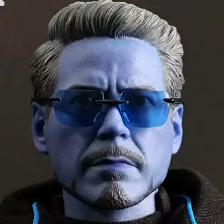

(224, 224, 3)


In [0]:
from PIL import Image

# url = 'https://media.karousell.com/media/photos/products/2018/08/20/16_scale_tony_stark_avenger3_headscrupt_with_glasses_1534759826_e79b0cf4.jpg'
# response = requests.get(url)
# image = Image.open(BytesIO(response.content))


sunglass = Image.open("/content/gdrive/My Drive/Colab Notebooks/16_scale_tony_stark_avenger3_headscrupt_with_glasses_1534759826_e79b0cf4.jpg.webp")
#image.save("test.jpg","jpeg")


#image = image.resize((224, 224), Image.ANTIALIAS)
sunglass = image.img_to_array(sunglass)
sunglass = cv2.resize(sunglass, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
cv2_imshow(sunglass)
print(sunglass.shape)

# y = np.expand_dims(sunglass, axis=0)
# y = preprocess_input(y)
# print(y.shape)


In [0]:
# preds = model.predict(y)
class_idx = 836
print(class_idx)
class_output = model.output[:, class_idx]
last_conv_layer = model.get_layer("block5_conv3")

836


In [0]:
grads = K.gradients(class_output, last_conv_layer.output)[0]
print(grads.shape)
pooled_grads = K.mean(grads, axis=(0, 1, 2))
print(pooled_grads.shape)
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

pooled_grads_value, conv_layer_output_value = iterate([x])

for i in range(450):
  conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

(?, 14, 14, 512)
(512,)


In [0]:
heatmap = np.mean(conv_layer_output_value, axis = -1)
print(conv_layer_output_value.shape)
print(heatmap.shape)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

(14, 14, 512)
(14, 14)


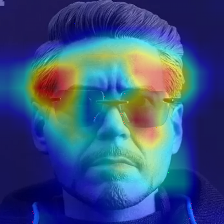

In [0]:
heatmap = cv2.resize(heatmap, (sunglass.shape[1],sunglass.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
sunglass = sunglass.astype(np.uint8)
superimposed_img = cv2.addWeighted(sunglass, 0.5, heatmap, 0.5, 0)

cv2_imshow(superimposed_img)


1. It is mentioned that all the convolutions are 3x3x3 filters.
2. The Conv/2 layer at the beginning of a contracting block has a stride of 2, thus reduces the size of each dimension by half.


>  Convolution    (f,p,s)	      Input 	          Output	        RF	      Jump

> Conv1	  3,1,0	 128x128x96	 128x128x96	 3x3x3	      1

>Conv2	  3,1,2	 128x128x96	 64x64x48	     5x5x5	      2

> Conv3	  3,1,0	  64x64x48	    64x64x48	   9x9x9	       4

> Conv4	  3,1,2	  64x64x48	    32x32x24	 13x13x13	   4

> Conv5	  3,1,0	  32x32x24	    32x32x24	 21x21x21	   8 

> Conv6	  3,1,2	  32x32x24	    16x16x12	 29x29x29	   8


End of contracting path				


> Conv7	  3,1,0	  16x16x12	    16x16x12	45x45x45	   16


3. The jump of RF from 29 to 45 is because the jump value is 16 = 8 x (stride = 2), thus 29 + 16 = 45.

